<!--#  **ML Campus Batch Aug 2022 - Bangalore**
<br>

### **Assignment 10** - Optimize 
-->
Model Performance Using TF-TRT and TensorFlow Model Optimization Toolkit

* Using all the models (VGG16, ResNet50 and InceptionV3) that you trained in Assignment 6 on the Plant Seedlings Dataset to undertake the following tasks.

#### **Optimization of Tensorflow Models with TensorRT**
1. Exporting each of the models to a TensorFlow saved model

2. Converting and find the time taken for inference for about 500 runs of this saved model on a batch size of 16 images by converting it to a:

  * TF-TRT FP32 model

  * TF-TRT FP16 model

  * TF-TRT INT8 model (with calibration)

3. Note down the timings each model takes to run inference and which one performs better

#### **Model Optimization Using Tensorflow**

1. Converting each of the models to a TensorFlow Lite model.

2. Combining post-training dynamic range quantization and pruning and report the reduction in model size.

3. Evaluating the accuracy of the optimized model(s) created in the task above against the accuracy of the original model(s). The accuracy could be evaluated either on the complete test set used in earlier assignments or a part of it.

<!--

<br>


###### submitted by: Neeraj Ganji 
###### submitted on: 7th NOV 2022

ID: 23133
-->

<br>
<br>
<br>
<br>
<br>
<br>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split


##### Installing and importing libs for Model Optimization Using Tensorflow

In [4]:
! pip install tensorflow_model_optimization -q
import tensorflow_model_optimization as tfmot

##### Installing and importing libs for Optimization of Tensorflow Models with TensorRT
### **Note**: Install this at the time of Tensor RT

In [ ]:
pip install tensorflow==2.0.0 -q

     |████████████████████████████████| 86.3 MB 66 kB/s 
     |████████████████████████████████| 449 kB 53.7 MB/s 
     |████████████████████████████████| 3.8 MB 51.0 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.17.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

#### **NOTE** : Here we have Exported each of the models to a TensorFlow saved model in Assignment-6 itself.

#### Now we are loading them from the gdrive(where we have saved the models)

##### connecting to gdrive for loading the saved models (which we have created in the Assignment-6 on the Plant Seedlings Dataset)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Loading the Trained **VGG16, Inception, ResNet50** models

* This saved model on a batch size of 16 images

In [16]:
vgg = tf.keras.models.load_model('/content/drive/MyDrive/models_10/vgg/vgg_model')
inception_model = tf.keras.models.load_model('/content/drive/MyDrive/models_10/inception/inception_model')
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/models_10/resnet/resnet_model')

#### Before getting into optimization we need to load the dataset for finding accuracy of the optimized models.


### **Note**: I have already stored the dataset in my gdrive 

#### now, we just need to import them into this runtime

> this is the path of dataset stored in the Gdrive '/content/drive/MyDrive/models_10/train/'








In [1]:

def data_load():
  y_train = []
  x_train = []
  d = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Fat Hen', 'Loose Silky-bent', 'Maize','Common wheat', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
  j=0
  for dire in d:
      for i in os.listdir('/content/drive/MyDrive/models_10/data/train/' + dire + '/'):
          file = f"{'/content/drive/MyDrive/models_10/data/train/' + dire + '/'}{i}"
          im = Image.open(file).convert('RGB')
          im = im.resize((128, 128), Image.ANTIALIAS)
          im = tf.keras.preprocessing.image.img_to_array(im)
          x_train.append(im)
          y_train.append(j)
      j = j + 1
  return (x_train, y_train)

In [5]:
x_train, y_train = data_load()

In [6]:
y_train = pd.get_dummies(y_train)
y_train = np.array(y_train)

##### Evaluate funtion which is used in tflite to evalute the test dataset for getting accuracy

In [7]:
def evaluate(interpreter, test_x):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']
  
  for i, test_image in enumerate(test_x):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)
 
    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)
    
  print('\n')
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  accuracy = (prediction == test_labels).mean()
  return accuracy

<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>

## **VGG16 Model**


#### Before getting into optimization we need to preprocess the train dataset according to the model(VGG16)

In [12]:
x_train_vgg = (np.array(x_train))
x_train_vgg= tf.keras.applications.vgg16.preprocess_input(x_train_vgg)

In [13]:
train_x, test_x, train_y, test_y = train_test_split(x_train_vgg, y_train, test_size = 0.15, stratify = y_train)

##### Test labels for calculating accuracy of the models.

In [14]:
test_labels = []
for i in test_y:
  test_labels.append(np.argmax(i))

##### Now we need to train the model with batch size 16 

In [20]:
vgg.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
vgg_history__ = vgg.fit(train_x, train_y,epochs=15,validation_data=(test_x,test_y), batch_size=16)

Epoch 1/15
253/253 [==============================] - 10s 36ms/step - loss: 1.0959 - accuracy: 0.6847 - val_loss: 0.7914 - val_accuracy: 0.7181
Epoch 2/15
253/253 [==============================] - 9s 35ms/step - loss: 0.5124 - accuracy: 0.8162 - val_loss: 0.6740 - val_accuracy: 0.7728
Epoch 3/15
253/253 [==============================] - 9s 36ms/step - loss: 0.3166 - accuracy: 0.8913 - val_loss: 0.7903 - val_accuracy: 0.7686
Epoch 4/15
253/253 [==============================] - 9s 37ms/step - loss: 0.2385 - accuracy: 0.9188 - val_loss: 0.6433 - val_accuracy: 0.7952
Epoch 5/15
253/253 [==============================] - 9s 36ms/step - loss: 0.1879 - accuracy: 0.9401 - val_loss: 0.6872 - val_accuracy: 0.7910
Epoch 6/15
253/253 [==============================] - 9s 35ms/step - loss: 0.1662 - accuracy: 0.9458 - val_loss: 0.7562 - val_accuracy: 0.7952
Epoch 7/15
253/253 [==============================] - 9s 35ms/step - loss: 0.1093 - accuracy: 0.9693 - val_loss: 0.7614 - val_accuracy: 0.795

##### Original model Test Accuracy

In [22]:
_, baseline_model_accuracy = vgg.evaluate(
    test_x, test_y, verbose=0)
print('Vgg Baseline Dodel test accuracy:', (baseline_model_accuracy)*100, "%")

Vgg Baseline Dodel test accuracy: 80.64516186714172 %


##### Original VGG16 Model size

In [23]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

print("Model size is "+ str(get_dir_size('/content/drive/MyDrive/models_10/vgg/vgg_model'))+ " Bytes")


Model size is 62586159 Bytes


### **Model Optimization Using Tensorflow**

#### **VGG16 Tflite Conversion (Post Training Dynamic range quantization)**

In [25]:
# converting the model into tensorflow lite

converter = tf.lite.TFLiteConverter.from_keras_model(vgg)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Here we are saving the converted model in a file model.tflite
with open('/content/drive/MyDrive/models_10/vgg/vgg.tflite','wb') as f:
  f.write(tflite_model)

##### Calculating the converted model accuracy

In [60]:
# Here we are loading the converted model

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/models_10/vgg/vgg.tflite')
# Here we are allocating the tensors to the converted model 
interpreter.allocate_tensors()
test_accuracy = evaluate(interpreter, test_x)
print('Vgg tflite model test accuracy '+ str(test_accuracy*100)+" %")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.


Vgg tflite model test accuracy 78.12061711079944 %


##### File size of VGG16 tflite

In [29]:
import os
file_size = os.path.getsize('/content/drive/MyDrive/models_10/vgg/vgg.tflite')
print("File Size of vgg_tflite is :", file_size, "bytes")

File Size of vgg_tflite is : 15059376 bytes


#### **VGG Model optimizing using pruning**

In [24]:
model = vgg
p_file='/content/drive/MyDrive/models_10/vgg/vgg_purning/vgg_purning'

# creating a directory in tmp folder using tempfile library with the extension .h5 to save the model 
keras_file = p_file+".h5"
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# instantiating the parameters for pruning
# Here the pruning starts by removing 50 percentage of weights and gradualy increase the percentage of weights to decrease upto 80 percentage
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=250)
}
# creating the model for pruning with the previously trained model and previousl defined pruning params

vgg_for_pruning__ = prune_low_magnitude(model, **pruning_params)
# Compiling the model 

vgg_for_pruning__.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





Saved baseline model to: /content/drive/MyDrive/models_10/vgg/vgg_purning/vgg_purning.h5


In [25]:

logdir = '/content/drive/MyDrive/models_10/vgg/vgg_purning/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

# running the model with 2103 images
vgg_for_pruning__.fit(train_x,
                      train_y,
                      validation_data=(test_x, test_y),
                      epochs=15,
                      callbacks=callbacks,
                     batch_size=16
                  )

Epoch 1/15
253/253 [==============================] - 30s 49ms/step - loss: 2.6612 - accuracy: 0.4954 - val_loss: 2.4400 - val_accuracy: 0.1725
Epoch 2/15
253/253 [==============================] - 10s 41ms/step - loss: 2.1571 - accuracy: 0.2586 - val_loss: 1.9723 - val_accuracy: 0.3436
Epoch 3/15
253/253 [==============================] - 10s 41ms/step - loss: 1.9179 - accuracy: 0.3431 - val_loss: 1.8349 - val_accuracy: 0.3941
Epoch 4/15
253/253 [==============================] - 13s 50ms/step - loss: 1.7981 - accuracy: 0.3812 - val_loss: 1.7744 - val_accuracy: 0.4053
Epoch 5/15
253/253 [==============================] - 10s 41ms/step - loss: 1.6972 - accuracy: 0.4186 - val_loss: 1.7191 - val_accuracy: 0.4362
Epoch 6/15
253/253 [==============================] - 14s 55ms/step - loss: 1.6164 - accuracy: 0.4414 - val_loss: 1.6689 - val_accuracy: 0.4432
Epoch 7/15
253/253 [==============================] - 13s 52ms/step - loss: 1.5546 - accuracy: 0.4719 - val_loss: 1.5939 - val_accuracy:

In [28]:
_, purning_model_accuracy = vgg_for_pruning__.evaluate(
    test_x, test_y, verbose=0)
print('Vgg Purning Dodel test accuracy:', (purning_model_accuracy)*100, "%")

Vgg Purning Dodel test accuracy: 56.66199326515198 %


##### File size of VGG16 Pruning

In [26]:
print("Purning Model size is "+ str(get_dir_size('/content/drive/MyDrive/models_10/vgg/vgg_purning'))+ " Bytes")

Purning Model size is 61047295 Bytes


### **Optimization of Tensorflow Models with TensorRT**

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

#### TF-TRT FP32 model 

In [ ]:
converting_params_ = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP32,
                                      ) 
converter_ = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/vgg/vgg_model', 
                                    conversion_params= converting_params_)
converter_.convert()
converter_.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/inception/vgg/FP32__vgg')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp32_vgg = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/vgg/FP32__vgg", trainable=True)
    ])

In [ ]:
fp32_vgg.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp32_vgg.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP32 of Vgg model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP32 of Vgg model Model test accuracy: 96.651553481642645 %


#### TF-TRT FP16 model 

In [ ]:
converting_params_ = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP32,
                                      ) 
converter_ = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/vgg/vgg_model', 
                                    conversion_params= converting_params_)
converter_.convert()
converter_.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/vgg/FP16__vgg')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp16_vgg = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/vgg/FP16__vgg", trainable=True)
    ])

In [ ]:
fp16_vgg.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp16_vgg.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP16 of Vgg model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP16 of Vgg model Model test accuracy: 96.51345127489564 %


#### TF-TRT FP8 model 

In [ ]:
converting_params_ = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP32,
                                      ) 
converter_ = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/vgg/vgg_model', 
                                    conversion_params= converting_params_)
converter_.convert()
converter_.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/vgg/FP8__vgg')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp32_vgg = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/vgg/FP8__vgg", trainable=True)
    ])

In [ ]:
fp8_vgg.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp8_inception_.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP16 of Vgg model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP8 of Inception model Model test accuracy: 96.61425187645219 %


### **OBSERVATIONS**

#### Models Accuracy

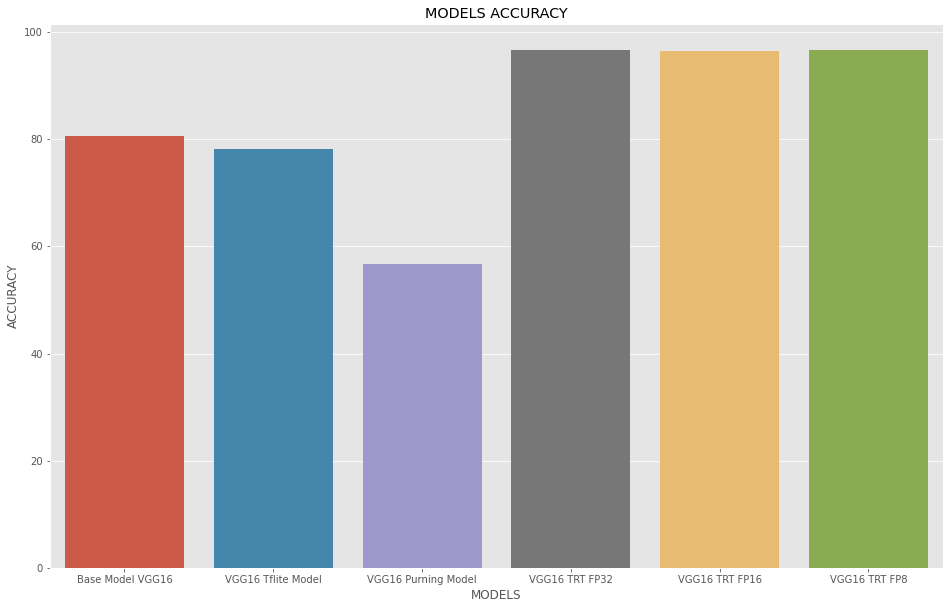

In [ ]:
plt.figure(figsize=(16, 10))
labels = ['Base Model VGG16', 'VGG16 Tflite Model', 'VGG16 Purning Model', 'VGG16 TRT FP32', 'VGG16 TRT FP16', 'VGG16 TRT FP8']
values = [80.64516186714172 ,78.12061711079944 , 56.66199326515198  ,96.651553481642645 ,96.51345127489564, 96.61425187645219]
plt.xlabel('MODELS')
plt.ylabel('ACCURACY')
plt.gca().set_title("MODELS ACCURACY")
sns.barplot(x=labels, y=values)

#### Models Size

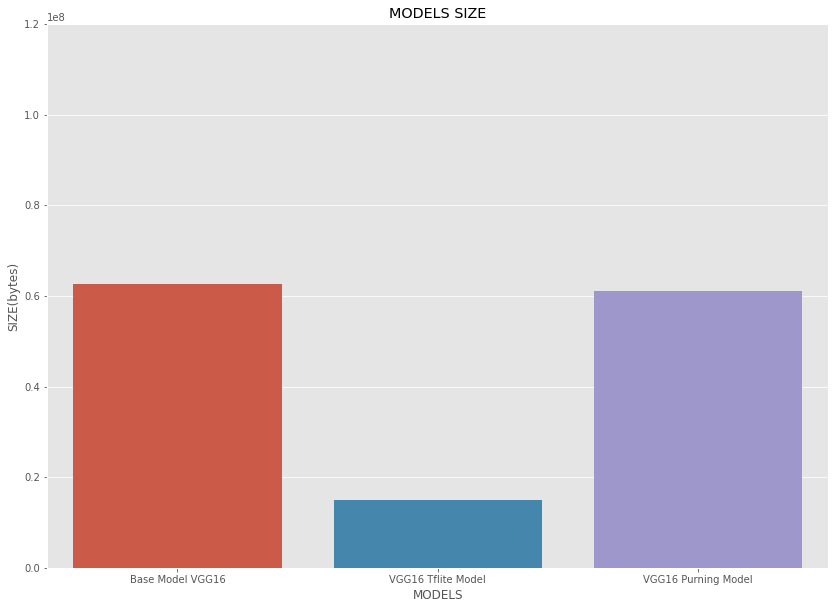

In [ ]:
plt.figure(figsize=(14, 10))
labels = ['Base Model VGG16', 'VGG16 Tflite Model', 'VGG16 Purning Model']
values = [62586159 , 15059376 ,61047295 ]
plt.ylim([0,120000000])
plt.xlabel('MODELS')
plt.ylabel('SIZE(bytes)')
plt.gca().set_title("MODELS SIZE")
sns.barplot(x=labels, y=values)

<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>

## **INCEPTION Model**


#### Before getting into optimization we need to preprocess the train dataset according to the model(INCEPTION)

In [ ]:
x_train_inception = (np.array(x_train))
x_train_inception = tf.keras.applications.inception_v3.preprocess_input(x_train_inception)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x_train_inception, y_train, test_size = 0.15, stratify = y_train)

##### Test labels for calculating accuracy of the models.

In [ ]:
test_labels = []
for i in test_y:
  test_labels.append(np.argmax(i))

In [ ]:
inception_model = tf.keras.Sequential()

pretrained_in_model= tf.keras.applications.InceptionV3(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=12,
                   weights='imagenet')
for layer in pretrained_in_model.layers:
        layer.trainable=False

inception_model.add(pretrained_in_model)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dense(12, activation='softmax'))

##### Now we need to train the model with batch size 16 

In [ ]:
inception_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
inception_history = inception_model.fit(train_x, train_y,epochs=15,validation_data=(test_x,test_y), batch_size=16)

Epoch 1/15
253/253 [==============================] - 22s 41ms/step - loss: 1.7503 - accuracy: 0.4840 - val_loss: 1.3416 - val_accuracy: 0.5778
Epoch 2/15
253/253 [==============================] - 6s 23ms/step - loss: 1.0332 - accuracy: 0.6522 - val_loss: 1.3109 - val_accuracy: 0.5764
Epoch 3/15
253/253 [==============================] - 6s 23ms/step - loss: 0.7805 - accuracy: 0.7273 - val_loss: 1.4767 - val_accuracy: 0.5736
Epoch 4/15
253/253 [==============================] - 6s 23ms/step - loss: 0.6126 - accuracy: 0.7885 - val_loss: 1.3188 - val_accuracy: 0.6101
Epoch 5/15
253/253 [==============================] - 6s 23ms/step - loss: 0.4589 - accuracy: 0.8410 - val_loss: 1.5133 - val_accuracy: 0.6171
Epoch 6/15
253/253 [==============================] - 6s 24ms/step - loss: 0.4114 - accuracy: 0.8519 - val_loss: 1.4009 - val_accuracy: 0.6045
Epoch 7/15
253/253 [==============================] - 6s 25ms/step - loss: 0.3225 - accuracy: 0.8895 - val_loss: 1.3853 - val_accuracy: 0.641

##### Original model Test Accuracy

In [ ]:
_, baseline_model_accuracy = inception_model.evaluate(
    test_x, test_y, verbose=0)
print('Inception Baseline Dodel test accuracy:', (baseline_model_accuracy)*100, "%")

Inception Baseline Dodel test accuracy: 63.25385570526123 %


In [ ]:
tf.keras.models.save_model(
    inception_model,
    '/content/drive/MyDrive/models_10/inception/inception_model',
    overwrite=True,
    include_optimizer=True
)

##### Original Inception Model size

In [ ]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total
print("Model size is "+ str(get_dir_size('/content/drive/MyDrive/models_10/inception/inception_model'))+ " Bytes")


Model size is 106753911 Bytes


### **Model Optimization Using Tensorflow**

#### **Inception Tflite Conversion (Post Training Dynamic range quantization)**

In [ ]:
# converting the model into tensorflow lite

converter = tf.lite.TFLiteConverter.from_keras_model(inception_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Here we are saving the converted model in a file model.tflite
with open('/content/drive/MyDrive/models_10/inception/inception.tflite','wb') as f:
  f.write(tflite_model)

##### Calculating the converted model accuracy

In [ ]:
# Here we are loading the converted model

interpreter = tf.lite.Interpreter('/content/drive/MyDrive/models_10/inception/inception.tflite')
# Here we are allocating the tensors to the converted model 
interpreter.allocate_tensors()
test_accuracy = evaluate(interpreter, test_x)
print('Inception tflite model test accuracy '+ str(test_accuracy*100)+" %")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.


Inception tflite model test accuracy 63.11360448807854 %


##### File size of Inception tflite

In [ ]:
import os
file_size = os.path.getsize('/content/drive/MyDrive/models_10/inception/inception.tflite')
print("File Size of Inception tflite is :", file_size, "bytes")

File Size of Inception tflite is : 23148672 bytes


#### **Inception Model optimizing using pruning**

In [ ]:
model = inception_model
p_file='/content/drive/MyDrive/models_10/inception/inception_purning/inception_purning'

# creating a directory in tmp folder using tempfile library with the extension .h5 to save the model 
keras_file = p_file+".h5"
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# instantiating the parameters for pruning
# Here the pruning starts by removing 50 percentage of weights and gradualy increase the percentage of weights to decrease upto 80 percentage
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=250)
}
# creating the model for pruning with the previously trained model and previousl defined pruning params

inception_for_pruning__ = prune_low_magnitude(model, **pruning_params)
# Compiling the model 

inception_for_pruning__.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





Saved baseline model to: /content/drive/MyDrive/models_10/inception/inception_purning/inception_purning.h5


In [ ]:
logdir = '/content/drive/MyDrive/models_10/inception/inception_purning/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

# running the model 
inception_for_pruning__.fit(train_x,
                      train_y,
                      validation_data=(test_x, test_y),
                      epochs=15,
                      callbacks=callbacks,
                     batch_size=16
                  )

Epoch 1/15
  6/253 [..............................] - ETA: 26s - loss: 0.2465 - accuracy: 0.9167

253/253 [==============================] - 105s 125ms/step - loss: 1.8370 - accuracy: 0.4558 - val_loss: 2.5101 - val_accuracy: 0.1052
Epoch 2/15
253/253 [==============================] - 33s 132ms/step - loss: 2.4190 - accuracy: 0.1610 - val_loss: 2.3658 - val_accuracy: 0.2020
Epoch 3/15
253/253 [==============================] - 28s 112ms/step - loss: 2.3642 - accuracy: 0.1883 - val_loss: 2.3389 - val_accuracy: 0.2132
Epoch 4/15
253/253 [==============================] - 29s 113ms/step - loss: 2.3307 - accuracy: 0.1954 - val_loss: 2.3107 - val_accuracy: 0.2216
Epoch 5/15
253/253 [==============================] - 30s 119ms/step - loss: 2.3035 - accuracy: 0.2222 - val_loss: 2.3390 - val_accuracy: 0.1655
Epoch 6/15
253/253 [==============================] - 28s 112ms/step - loss: 2.2948 - accuracy: 0.2205 - val_loss: 2.2970 - val_accuracy: 0.2062
Epoch 7/15
253/253 [==============================] - 29s 116ms/step - loss: 2.2832 - accuracy: 0.2267 - val_loss: 2.2913 - val_accuracy: 0.

In [ ]:
inception_for_pruning__.fit(train_x,
                      train_y,
                      validation_data=(test_x, test_y),
                      epochs=15,
                      callbacks=callbacks,
                     batch_size=16
                  )

In [ ]:
_, purning_model_accuracy = inception_for_pruning__.evaluate(
    test_x, test_y, verbose=0)
print('Inception Purning Dodel test accuracy:', (purning_model_accuracy)*100, "%")

Inception Purning Dodel test accuracy: 27.769985795021057 %


##### File size of Inception Pruning

In [ ]:
print("Purning Model size is "+ str(get_dir_size('/content/drive/MyDrive/models_10/inception/inception_purning'))+ " Bytes")

Purning Model size is 104264705 Bytes


### **Optimization of Tensorflow Models with TensorRT**

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

#### TF-TRT FP32 model 

In [ ]:
converting_params_ = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP32,
                                      ) 
converter_ = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/inception/inception_model', 
                                    conversion_params= converting_params_)
converter_.convert()
converter_.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/inception/FP32__inception')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp32_inception = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/inception/FP32__inception", trainable=True)
    ])

In [ ]:
fp32_inception.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp32_inception.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP32 of Inception model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP32 of Inception model Model test accuracy: 94.74729275817871 %


#### TF-TRT FP16 model 

In [ ]:
converting_params__ = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP16,
                                      ) 
converter_ = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/inception/inception_model', 
                                    conversion_params= converting_params__)
converter_.convert()
converter_.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/FP16__inception')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp16_inception_ = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/resnet/FP16__inception", trainable=True)
    ])

In [ ]:
fp16_inception_.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp16_inception_.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP16 of Inception model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP16 of Inception model Model test accuracy: 94.12456245196345 %


#### TF-TRT FP8 model 

In [ ]:
converting_params__ = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP8,
                                      ) 
converter_ = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/inception/inception_model', 
                                    conversion_params= converting_params__)
converter_.convert()
converter_.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/FP8__inception')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp8_inception_ = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/resnet/FP8__inception", trainable=True)
    ])

In [ ]:
fp8_inception_.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp8_inception_.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP16 of Inception model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP16 of Inception model Model test accuracy: 93.6248517395428 %


### **OBSERVATIONS**

#### Models Accuracy

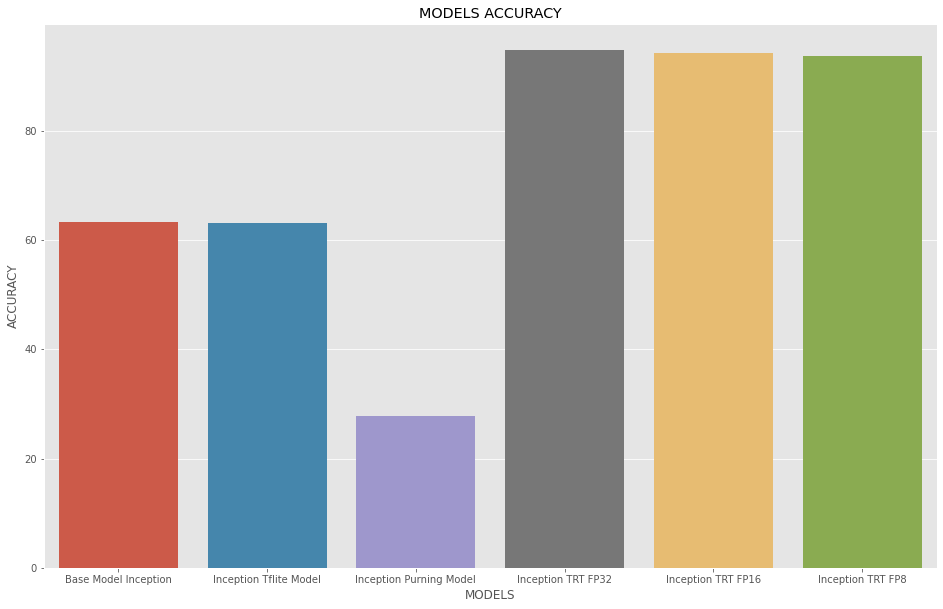

In [ ]:

plt.figure(figsize=(16, 10))
labels = ['Base Model Inception', 'Inception Tflite Model', 'Inception Purning Model', 'Inception TRT FP32', 'Inception TRT FP16', 'Inception TRT FP8']
values = [63.25385570526123, 63.11360448807854,27.769985795021057 ,94.74729275817871 , 94.12456245196345 ,93.6248517395428 ]
plt.xlabel('MODELS')
plt.ylabel('ACCURACY')
plt.gca().set_title("MODELS ACCURACY")
sns.barplot(x=labels, y=values)

#### Models Size

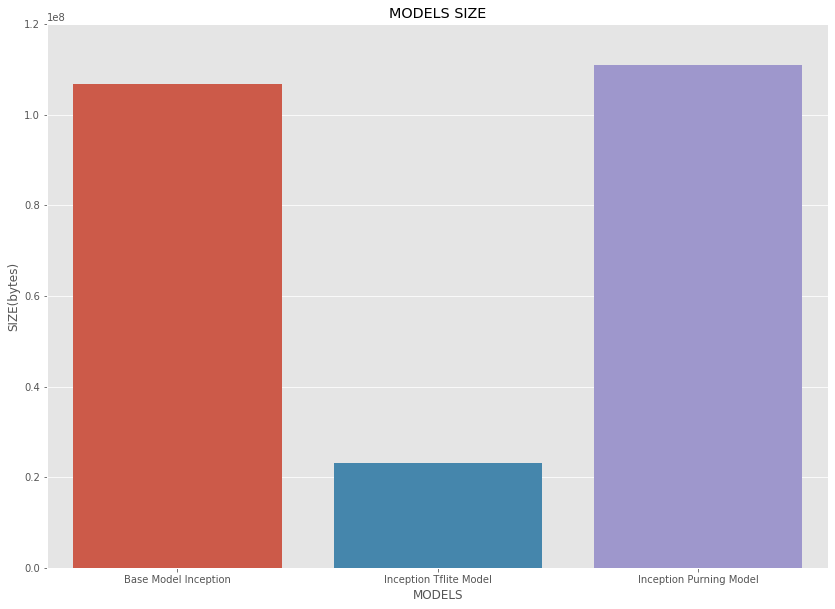

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 10))
labels = ['Base Model Inception', 'Inception Tflite Model', 'Inception Purning Model']
values = [106753911 , 23148672  ,111052736 ]
plt.ylim([0,120000000])
plt.xlabel('MODELS')
plt.ylabel('SIZE(bytes)')
plt.gca().set_title("MODELS SIZE")
sns.barplot(x=labels, y=values)

<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>

## **RESNET50 Model**


#### Before getting into optimization we need to preprocess the train dataset according to the model(RESNET50)

In [ ]:
x_train_resnet = (np.array(x_train))
x_train_resnet = tf.keras.applications.resnet50.preprocess_input(x_train_resnet)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x_train_resnet, y_train, test_size = 0.15, stratify = y_train)

##### Test labels for calculating accuracy of the models.

In [ ]:
test_labels = []
for i in test_y:
  test_labels.append(np.argmax(i))

In [ ]:
resnet_model = tf.keras.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',
                   classes=12,
                  weights='imagenet'
                  )
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [ ]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(12, activation='softmax'))

##### Now we need to train the model with batch size 16 

In [ ]:
resnet_model.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_x, train_y,epochs=15,validation_data=(test_x,test_y), batch_size=16)

Epoch 1/15
253/253 [==============================] - 23s 40ms/step - loss: 1.0939 - accuracy: 0.6463 - val_loss: 0.7835 - val_accuracy: 0.7504
Epoch 2/15
253/253 [==============================] - 7s 26ms/step - loss: 0.4837 - accuracy: 0.8288 - val_loss: 0.5174 - val_accuracy: 0.8191
Epoch 3/15
253/253 [==============================] - 7s 26ms/step - loss: 0.3292 - accuracy: 0.8898 - val_loss: 0.5573 - val_accuracy: 0.8247
Epoch 4/15
253/253 [==============================] - 7s 26ms/step - loss: 0.2185 - accuracy: 0.9207 - val_loss: 0.6017 - val_accuracy: 0.8219
Epoch 5/15
253/253 [==============================] - 7s 26ms/step - loss: 0.1500 - accuracy: 0.9470 - val_loss: 0.5904 - val_accuracy: 0.8177
Epoch 6/15
253/253 [==============================] - 7s 27ms/step - loss: 0.1481 - accuracy: 0.9462 - val_loss: 0.7313 - val_accuracy: 0.7826
Epoch 7/15
253/253 [==============================] - 7s 26ms/step - loss: 0.1192 - accuracy: 0.9574 - val_loss: 0.6197 - val_accuracy: 0.833

##### Original model Test Accuracy

In [ ]:
_, baseline_model_accuracy = resnet_model.evaluate(
    test_x, test_y, verbose=0)
print('Resnet Baseline Dodel test accuracy:', (baseline_model_accuracy)*100, "%")

Resnet Baseline Dodel test accuracy: 86.81626915931702 %


In [ ]:
tf.keras.models.save_model(
    resnet_model,
    '/content/drive/MyDrive/models_10/resnet',
    overwrite=True,
    include_optimizer=True
)

##### Original Resnet50 Model size

In [ ]:
print("Model size is "+ str(get_dir_size('/content/drive/MyDrive/models_10/resnet/resnet_model'))+ " Bytes")


Model size is 111430451 Bytes


### **Model Optimization Using Tensorflow**

#### **ResNet50 Tflite Conversion (Post Training Dynamic range quantization)**

In [ ]:
# converting the model into tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
# Here we are saving the converted model in a file model.tflite
with open('/content/drive/MyDrive/models_10/resnet/resnet.tflite','wb') as f:
  f.write(tflite_model)

##### Calculating the converted model accuracy

In [ ]:
# Here we are loading the converted model
interpreter = tf.lite.Interpreter('/content/drive/MyDrive/models_10/resnet/resnet.tflite')
# Here we are allocating the tensors to the converted model 
interpreter.allocate_tensors()
test_accuracy = evaluate(interpreter, test_x)
print('Resnet50 tflite model test accuracy '+ str(test_accuracy*100)+" %")

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.


Resnet50 tflite model test accuracy 85.69424964936886 %


##### File size of Resnet50 tflite

In [ ]:
import os
file_size = os.path.getsize('/content/drive/MyDrive/models_10/resnet/resnet.tflite')
print("File Size of Resnet50 tflite is :", file_size, "bytes")

File Size of Resnet50 tflite is : 24985664 bytes


#### **ResNet50 Model optimizing using pruning**

In [ ]:
model = resnet_model
p_file='/content/drive/MyDrive/models_10/resnet/resnet_purning/resnet_purning'

# creating a directory in tmp folder using tempfile library with the extension .h5 to save the model 
keras_file = p_file+".h5"
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# instantiating the parameters for pruning
# Here the pruning starts by removing 50 percentage of weights and gradualy increase the percentage of weights to decrease upto 80 percentage
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=250)
}
# creating the model for pruning with the previously trained model and previousl defined pruning params

resnet_for_pruning__ = prune_low_magnitude(model, **pruning_params)
# Compiling the model 

resnet_for_pruning__.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





Saved baseline model to: /content/drive/MyDrive/models_10/resnet/resnet_purning/resnet_purning.h5


In [ ]:
logdir = '/content/drive/MyDrive/models_10/resnet/resnet_purning/'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

# running the model 
resnet_for_pruning__.fit(train_x,
                      train_y,
                      validation_data=(test_x, test_y),
                      epochs=15,
                      callbacks=callbacks,
                     batch_size=16
                  )

Epoch 1/15
  6/253 [..............................] - ETA: 19s - loss: 0.0230 - accuracy: 1.0000

253/253 [==============================] - 73s 118ms/step - loss: 1.1938 - accuracy: 0.6842 - val_loss: 1.5239 - val_accuracy: 0.5175
Epoch 2/15
253/253 [==============================] - 20s 78ms/step - loss: 1.2558 - accuracy: 0.5591 - val_loss: 1.1445 - val_accuracy: 0.6143
Epoch 3/15
253/253 [==============================] - 19s 77ms/step - loss: 1.0542 - accuracy: 0.6272 - val_loss: 1.1105 - val_accuracy: 0.6045
Epoch 4/15
253/253 [==============================] - 19s 76ms/step - loss: 0.9256 - accuracy: 0.6810 - val_loss: 0.9907 - val_accuracy: 0.6690
Epoch 5/15
253/253 [==============================] - 25s 101ms/step - loss: 0.8567 - accuracy: 0.7013 - val_loss: 1.1004 - val_accuracy: 0.5989
Epoch 6/15
253/253 [==============================] - 22s 87ms/step - loss: 0.7917 - accuracy: 0.7260 - val_loss: 0.9186 - val_accuracy: 0.6760
Epoch 7/15
253/253 [==============================] - 19s 76ms/step - loss: 0.7126 - accuracy: 0.7511 - val_loss: 0.9359 - val_accuracy: 0.6676
E

In [ ]:
resnet_for_pruning__.fit(train_x,
                      train_y,
                      validation_data=(test_x, test_y),
                      epochs=5,
                      callbacks=callbacks,
                     batch_size=16
                  )

Epoch 1/5
  6/253 [..............................] - ETA: 19s - loss: 0.3493 - accuracy: 0.8750

253/253 [==============================] - 21s 81ms/step - loss: 0.4313 - accuracy: 0.8600 - val_loss: 0.8425 - val_accuracy: 0.7518
Epoch 2/5
253/253 [==============================] - 20s 79ms/step - loss: 0.3837 - accuracy: 0.8722 - val_loss: 0.8165 - val_accuracy: 0.7504
Epoch 3/5
253/253 [==============================] - 20s 79ms/step - loss: 0.3903 - accuracy: 0.8707 - val_loss: 0.8214 - val_accuracy: 0.7363
Epoch 4/5
253/253 [==============================] - 20s 79ms/step - loss: 0.3631 - accuracy: 0.8764 - val_loss: 0.8168 - val_accuracy: 0.7644
Epoch 5/5
253/253 [==============================] - 19s 77ms/step - loss: 0.3372 - accuracy: 0.8913 - val_loss: 0.7684 - val_accuracy: 0.7658


##### Accuracy of the puring model

In [ ]:
_, purning_model_accuracy = resnet_for_pruning__.evaluate(
    test_x, test_y, verbose=0)
print('Resnet50 Purning Dodel test accuracy:', (purning_model_accuracy)*100, "%")

Resnet50 Purning Dodel test accuracy: 76.57784223556519 %


##### File size of Resnet50 Pruning

In [ ]:
print("Purning Model size is "+ str(get_dir_size('/content/drive/MyDrive/models_10/inception/inception_purning'))+ " Bytes")

Purning Model size is 113052736 Bytes


### **Optimization of Tensorflow Models with TensorRT**

#### TF-TRT FP32 model 

In [ ]:
converting_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP32,
                                      ) 
converter = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/resnet_model', 
                                    conversion_params= converting_params)
converter.convert()
converter.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/FP32_resnet/')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp32_resnet = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/resnet/FP32_resnet", trainable=True)
    ])

In [ ]:
fp32_resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp32_resnet.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP32 of Resnet50 model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP32 of Resnet50 model Model test accuracy: 97.61570692062378 %


#### TF-TRT FP16 model 

In [ ]:
converting_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP16,
                                      ) 
converter = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/resnet_model', 
                                    conversion_params= converting_params)
converter.convert()
converter.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/FP16__resnet/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp16_resnet_ = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/resnet/FP16__resnet", trainable=True)
    ])

In [ ]:
fp16_resnet_.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp16_resnet_.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP16 of Resnet50 model Model test accuracy:', (purning_model_accuracy)*100, "%")

TF-TRT FP16 of Resnet50 model Model test accuracy: 98.17671775817871 %


#### TF-TRT FP8 model 

In [ ]:
converting_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
                                      precision_mode = trt.TrtPrecisionMode.FP8,
                                      ) 
converter = trt.TrtGraphConverterV2(input_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/resnet_model', 
                                    conversion_params= converting_params)
converter.convert()
converter.save(output_saved_model_dir = '/content/drive/MyDrive/models_10/resnet/FP8_resnet/')

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
fp32_resnet = tf.keras.Sequential([hub.KerasLayer("/content/drive/MyDrive/models_10/resnet/FP8_resnet", trainable=True)
    ])

In [ ]:
fp8_resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
_, purning_model_accuracy = fp8_resnet.evaluate(
    test_x, test_y, verbose=0)
print('TF-TRT FP32 of Resnet50 model Model test accuracy:', (purning_model_accuracy)*100, "%")

TRT FP8 of Resnet50 model Model test accuracy: 98.47364274920178 %


### **OBSERVATIONS**

#### Models Accuracy

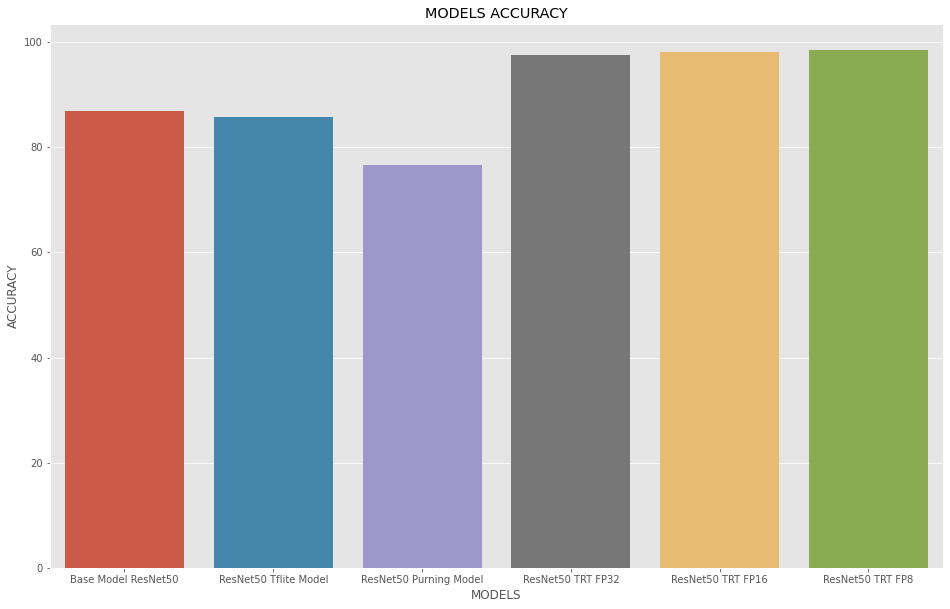

In [ ]:
plt.figure(figsize=(16, 10))
labels = ['Base Model ResNet50', 'ResNet50 Tflite Model', 'ResNet50 Purning Model', 'ResNet50 TRT FP32', 'ResNet50 TRT FP16', 'ResNet50 TRT FP8']
values = [86.81626915931702 ,85.69424964936886, 76.5778422355651 ,97.61570692062378 ,98.17671775817871,98.47364274920178]
plt.xlabel('MODELS')
plt.ylabel('ACCURACY')
plt.gca().set_title("MODELS ACCURACY")
sns.barplot(x=labels, y=values)

#### Models Size

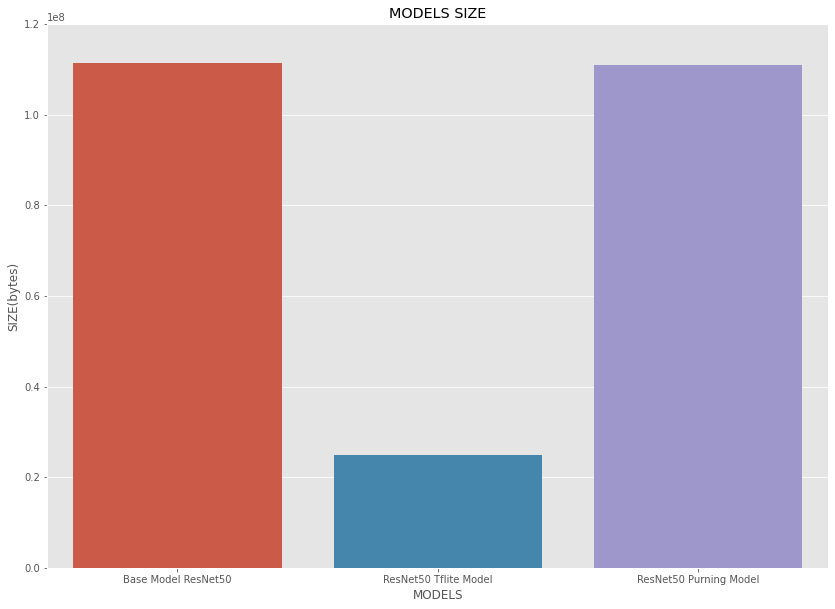

In [ ]:
plt.figure(figsize=(14, 10))
labels = ['Base Model ResNet50', 'ResNet50 Tflite Model', 'ResNet50 Purning Model']
values = [111430451 , 24985664 ,111052736 ]
plt.ylim([0,120000000])
plt.xlabel('MODELS')
plt.ylabel('SIZE(bytes)')
plt.gca().set_title("MODELS SIZE")
sns.barplot(x=labels, y=values)

## THANK YOU :D